# Project: Have Reviews of Yankee Candle Products Been Impacted by the Coronavirus Pandemic?

**Objective:** Use natural language processing and sentiment analysis to research the impact of the coronavirus pandemic on the review of Yankee Candle products on Amazon.

**Hypothesis:** That average review ratings and sentiment for Yankee Candle products on Amazon have decreased in 2020, when compared to previous years, due to the common coronavirus sympton of a loss of smell. My assertion is that purchasers of Yankee Candles blame the manufacturer for a lack of scent in the product, without realizing it is their own health condition that is at fault.

**Tools Used:** Python, Pandas, Scrapy, NLTK, Gensim, TextBlob, VADER Sentiment Analysis, scikit-learn, Matplotlib, Seaborn, 

**Skills Demonstrated:** Web Scraping, Data Cleaning, Feature Extraction, Exploratory Data Analysis, Natural Language Processing (Sentiment Analysis, Topic Modelling), Data Visualization

# Part A: Web Scraping and Data Cleaning

For this project, I will need to create a dataset of product reviews by scraping Yankee Candle product pages on Amazon.  To obtain 30,000 reviews I will need to scrape review pages for 10 Yankee Candle products:
* B0014SUGEW - Yankee Candle Large Jar Candle, Wedding Day 
* B0044R5L6S - Yankee Candle Large Jar Candle, Sparkling Snow 
* B07FD45KN8 - Yankee Candle Large Jar Scented Candle, Autumn Pearl 
* B075TJR2XK - Yankee Candle Large Jar Candle, Balsam & Clove 
* B001WMKT2O - Yankee Candle Large 2-Wick Tumbler Candle, Beach Walk 
* B003CJ27Q6 - Yankee Candle Large 2-Wick Tumbler Candle, MidSummer's Night
* B071Y5RJM1 - Yankee Candle Fragrance Spheres, MidSummer's Night
* B000W3T9GG - Yankee Candle Large Jar Candle French Vanilla
* B000ORX6WI - Yankee Candle Large Jar Candle Midsummer's Night
* B008P8YTU6 - Yankee Candle Large Jar Candle, Apple Pumpkin
* B00LBYSNNA - Yankee Candle Large 2-Wick Tumbler Candle, Silver Birch

## 1. Build a Spider
**Objective:** Build a spider using Scrapy to scrape Yankee Candle product reviews from Amazon.

In [1]:
import scrapy

class YankeeSpider(scrapy.Spider):
    name = "yankeespider"
    baseURL = []
    baseURL.append("https://www.amazon.com/product-reviews/B0014SUGEW/ref=cm_cr_arp_d_viewopt_srt?pageNumber=")
    baseURL.append("https://www.amazon.com/product-reviews/B0044R5L6S/ref=cm_cr_arp_d_viewopt_srt?pageNumber=")
    baseURL.append("https://www.amazon.com/product-reviews/B07FD45KN8/ref=cm_cr_arp_d_viewopt_srt?pageNumber=")
    baseURL.append("https://www.amazon.com/product-reviews/B075TJR2XK/ref=cm_cr_arp_d_viewopt_srt?pageNumber=")
    baseURL.append("https://www.amazon.com/product-reviews/B001WMKT2O/ref=cm_cr_arp_d_viewopt_srt?pageNumber=")
    baseURL.append("https://www.amazon.com/product-reviews/B071Y5RJM1/ref=cm_cr_arp_d_viewopt_srt?pageNumber=")
    baseURL.append("https://www.amazon.com/product-reviews/B000W3T9GG/ref=cm_cr_arp_d_viewopt_srt?pageNumber=")
    baseURL.append("https://www.amazon.com/product-reviews/B000ORX6WI/ref=cm_cr_arp_d_viewopt_srt?pageNumber=")
    baseURL.append("https://www.amazon.com/product-reviews/B008P8YTU6/ref=cm_cr_arp_d_viewopt_srt?pageNumber=")
    baseURL.append("https://www.amazon.com/product-reviews/B0014SUGEW/ref=cm_cr_arp_d_viewopt_srt?pageNumber=")
    
    start_urls = []
    
    # Create a list of URLs to be scraped, by appending a page number to the end of the base URL.
    for j in range(10):
        for i in range(1,550):
            start_urls.append(baseURL[j] + str(i))
        
    def parse(self, response):
        for row in response.css('div.review'):
            
            item = {}
            
            item['Title'] = row.xpath('.//a[@data-hook="review-title"]/span/text()').extract()

            item['Author'] = row.css('span.a-profile-name::text').extract()
                        
            item['Date'] = row.css('span.review-date::text').extract_first()
            
            item['Rating'] = int(float(row.css('i.review-rating > span::text').extract_first().strip().split(' ')[0].strip().replace(',', '.')))

            item['Product'] = row.xpath('.//a[@data-hook="format-strip"]//text()').extract()
            
            item['Helpfulness'] = row.css('span.cr-vote-text::text').extract_first()
                 
            # Remove leading and trailing spaces from review.
            trans_table = {ord(c): None for c in u'\r\n\t'}
            item['Content'] = ' '.join(s.translate(trans_table) for s in row.xpath('.//span[@data-hook="review-body"]//text()').extract()).lstrip()

            yield item

## 2. Run the Spider

I used the following command from the console to run the above spider and output the results to a CSV file:

*scrapy crawl yankeespider -o reviews.csv*

I performed the scraping on 2021-01-03.  In all, 31,182 product reviews were scraped, including title, author, rating, helpfulness, date, product name and review.  Amazon groups products and product reviews in parent-child relationships, therefore the scraped reviews represent more products than just those listed above.

## 3. Clean the Scraped Data

**Objective:** Clean the scraped data by addressing null values and correcting data types.

In [2]:
import pandas as pd
df = pd.read_csv('reviews.csv')

df.shape

(31182, 7)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31182 entries, 0 to 31181
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        27591 non-null  object
 1   Author       31181 non-null  object
 2   Date         31182 non-null  object
 3   Rating       31182 non-null  int64 
 4   Product      30669 non-null  object
 5   Helpfulness  5969 non-null   object
 6   Content      31179 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.7+ MB


There are 3,591 observations in the dataset without a Title. As I will not be using this field in my analysis, the missing values are of no concern.  The missing values for Product are also of no concern.  Null values are expected for Helpfulness.

I will address the null values in the Content field next.

In [4]:
# Drop observations without review text.
df.dropna(subset=['Content'], inplace=True)

# Change the Helpfulness feature to a numeric value, representing the number of people who thought a review was helpful 
def h_mod(text):
    if isinstance(text, float):
        return 0
    elif text.split()[0] == 'One':
        return 1
    else:
        return text.split()[0]

df['Helpfulness'] = df['Helpfulness'].apply(lambda x: h_mod(x))
df['Helpfulness'] = pd.to_numeric(df['Helpfulness'])
    
# Change the Date feature to date data type.
def d_mod(text):
    return text.split('on',1)[1] 
df['Date'] = df['Date'].apply(lambda x: d_mod(x))
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True, errors='coerce')

# Drop observations after 12/31/2020, as January 2021 has few observations and will skew the analysis.
df = df[df['Date'] < '2020-12-31']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31121 entries, 0 to 31181
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Title        27538 non-null  object        
 1   Author       31120 non-null  object        
 2   Date         31121 non-null  datetime64[ns]
 3   Rating       31121 non-null  int64         
 4   Product      30608 non-null  object        
 5   Helpfulness  31121 non-null  int64         
 6   Content      31121 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 1.9+ MB


In [6]:
display(df)

,Title,Author,Date,Rating,Product,Helpfulness,Content
0,Don't Order Candles When You're Drunk,Rachel,2018-09-28,1,"Size: Large Jar,Style: A Calm & Quiet Place,Pa...",262,"As the title states, I suggest that you do not..."
1,Nice scent but something went wrong,Hayley,2020-11-05,1,"Size: Large Jar,Style: Midnight Jasmine,Patter...",1,"I love candles, especially jasmine scented one..."
2,"I am almost, happy with this candle",Shepard,2017-06-23,4,"Size: Large Jar,Style: White Gardenia,Pattern ...",7,"I am almost, happy with this candle. For some..."
3,Another Great Find,Penny's picks,2017-06-26,5,"Size: Large Jar,Style: White Gardenia,Pattern ...",7,I love Yankee candles! I've never been disapp...
4,Hair in my candle,Gabi,2018-12-12,1,"Size: Large Jar,Style: Fresh Cut Roses,Pattern...",232,Y’all is NASTY. So I open up the candle and it...
...,...,...,...,...,...,...,...
31177,NaN,Tasha,2013-06-11,5,"Size: Large Jar,Style: Beach Walk,Pattern Name...",1,"YANKEE ALWAYS DELIVERS EXCELLENT PRODUCTS, THI..."
31178,NaN,Mrs Janet Force,2016-01-19,5,"Size: Large Jar,Style: Lavender,Pattern Name: ...",0,love it
31179,NaN,Kevin Cai,2017-07-24,4,"Size: Large Jar,Style: Fresh Cut Roses,Pattern...",0,"love the rose smelling, but it has only one ca..."
31180,NaN,Regina,2015-08-15,5,"Size: Medium Jar,Style: Beach Walk,Pattern Nam...",0,"Ein Traum von duft, bei diesem kauf kann man n..."


# Part B: Feature Extraction & Data Pre-Processing

## 1. Feature Extraction
**Objective:** Before pre-processing the dataset I will extract features that I will not be able to extract afterwards.

### 1.1 Determine Number of Stop Words

In [7]:
from nltk.corpus import stopwords
import string

# Exclude 'not' and 'no' from stop word list as these words are needed for sentiment analysis.
stop = set(stopwords.words('english')) - set(['not', 'no'])
df['NumStopWords'] = df['Content'].apply(lambda x: len([x for x in x.split() if x in stop]))

df[['Content','NumStopWords']].head()

,Content,NumStopWords
0,"As the title states, I suggest that you do not...",89
1,"I love candles, especially jasmine scented one...",31
2,"I am almost, happy with this candle. For some...",21
3,I love Yankee candles! I've never been disapp...,13
4,Y’all is NASTY. So I open up the candle and it...,61


### 1.2 Determine Number of Punctuation

In [8]:
def punctuation(text):
    return sum([1 for char in text if char in string.punctuation])

df['NumPunctuation'] = df['Content'].apply(lambda x: punctuation(x))

df[['Content','NumPunctuation']].head()

,Content,NumPunctuation
0,"As the title states, I suggest that you do not...",18
1,"I love candles, especially jasmine scented one...",12
2,"I am almost, happy with this candle. For some...",13
3,I love Yankee candles! I've never been disapp...,9
4,Y’all is NASTY. So I open up the candle and it...,13


### 1.3 Determine Number of Hashtags

In [9]:
df['NumHashtags'] = df['Content'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

df[['Content','NumHashtags']].head()

,Content,NumHashtags
0,"As the title states, I suggest that you do not...",0
1,"I love candles, especially jasmine scented one...",0
2,"I am almost, happy with this candle. For some...",0
3,I love Yankee candles! I've never been disapp...,0
4,Y’all is NASTY. So I open up the candle and it...,0


### 1.4 Determine Number of Numerical Values

In [10]:
df['NumNumerics'] = df['Content'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

df[['Content','NumNumerics']].head()

,Content,NumNumerics
0,"As the title states, I suggest that you do not...",0
1,"I love candles, especially jasmine scented one...",0
2,"I am almost, happy with this candle. For some...",0
3,I love Yankee candles! I've never been disapp...,0
4,Y’all is NASTY. So I open up the candle and it...,0


### 1.5 Determine Number of Uppercase Words

In [11]:
df['NumUpper'] = df['Content'].apply(lambda x: len([x for x in x.split() if x.isupper()]))

df[['Content','NumUpper']].head()

,Content,NumUpper
0,"As the title states, I suggest that you do not...",13
1,"I love candles, especially jasmine scented one...",5
2,"I am almost, happy with this candle. For some...",5
3,I love Yankee candles! I've never been disapp...,2
4,Y’all is NASTY. So I open up the candle and it...,8


### 1.6 Number of Words and Characters, Average Word Length

In [12]:
df['NumWords'] = df['Content'].apply(lambda x: len(str(x).split(" ")))
df[['Content','NumWords']].head()

,Content,NumWords
0,"As the title states, I suggest that you do not...",188
1,"I love candles, especially jasmine scented one...",93
2,"I am almost, happy with this candle. For some...",68
3,I love Yankee candles! I've never been disapp...,42
4,Y’all is NASTY. So I open up the candle and it...,153


In [13]:
df['NumChars'] = df['Content'].str.len()
df[['Content','NumChars']].head()

,Content,NumChars
0,"As the title states, I suggest that you do not...",948
1,"I love candles, especially jasmine scented one...",507
2,"I am almost, happy with this candle. For some...",330
3,I love Yankee candles! I've never been disapp...,240
4,Y’all is NASTY. So I open up the candle and it...,716


In [14]:
def avg_word(text):
    words = text.split()
    return (sum(len(word) for word in words)/(len(words)))

df['AvgWordLength'] = df['Content'].apply(lambda x: avg_word(x)).round(1)
df[['Content','AvgWordLength']].head()

,Content,AvgWordLength
0,"As the title states, I suggest that you do not...",4.1
1,"I love candles, especially jasmine scented one...",4.6
2,"I am almost, happy with this candle. For some...",4.2
3,I love Yankee candles! I've never been disapp...,5.4
4,Y’all is NASTY. So I open up the candle and it...,3.8


### 1.7 Good Review or Bad Review
**Objective:** Classify each review as either good or bad.

Amazon reviews have an associated rating from 1 to 5, with 5 being the highest and best rating.  I will define good reviews as reviews with a rating of 4 or 5.  A review is not good if it has a rating of 3 or less.

In [15]:
def score(s):
    if s <= 3:
        return 0
    else:
        return 1

df['Good Review'] = df.apply(lambda x: score(x['Rating']), axis=1)

In [16]:
df.sample(5)

,Title,Author,Date,Rating,Product,Helpfulness,Content,NumStopWords,NumPunctuation,NumHashtags,NumNumerics,NumUpper,NumWords,NumChars,AvgWordLength,Good Review
20339,"Light, Sweet Vanilla Scent",Beth,2017-08-26,4,"Size: Large Jar,Style: Buttercream,Pattern Nam...",0,I purchased this directly from a Yankee Candle...,53,15,0,1,5,132,658,4.2,1
23885,NaN,Stefania,2019-10-16,5,"Size: Medium Jar,Style: Soft Blanket,Pattern N...",0,Ottimo prodotto . Una fragranza buonissima e s...,0,3,0,0,0,17,91,6.2,1
19054,Love everything about Yankee candles!,GinnyA,2020-12-05,5,"Size: Large Jar,Style: Vanilla Cupcake,Pattern...",1,I buy these for myself and gifts. The scent is...,8,3,0,0,1,21,93,4.1,1
6075,Sugar cookies YUM!!!,Solanyi,2017-01-04,5,"Size: Large Jar,Style: Christmas Cookie,Patter...",0,I got this today and within 5 mins my house sm...,3,3,0,1,1,15,65,4.2,1
24936,Love the smell,Alexis,2020-01-25,5,"Size: Large Jar,Style: Spiced Pumpkin,Pattern ...",0,Love the smell. Haven't had it long enough to ...,10,3,0,0,1,25,103,3.6,1


## 2. Data Pre-Processing
**Objective:** Pre-process the dataset ready to perform sentiment analysis and other analysis.

### 2.1 Make All Text Lower Case

In [17]:
df['Content'] = df['Content'].apply(lambda x: " ".join(x.lower() for x in x.split()))

### 2.2 Remove Punctuation

In [18]:
df['Content'] = df['Content'].str.replace('[^\w\s]','')

### 2.3 Remove URLs and HTML Tags

In [19]:
import re

def remove_url(text): 
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

df['Content'] = df['Content'].apply(lambda x: remove_url(x))

In [20]:
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

df['Content'] = df['Content'].apply(lambda x: remove_html(x))

### 2.4 Remove Emojis & Emoticons

In [21]:
def remove_emoji(text): 
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df['Content'] = df['Content'].apply(lambda x: remove_emoji(x))

In [22]:
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in   EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)

df['Content'] = df['Content'].apply(lambda x: remove_emoticons(x))

### 2.5 Correct Spelling
As this is very computationally expensive, I am correcting spelling only for the first 100 observations in the dataset.

In [23]:
from textblob import TextBlob
df['Content'][:100].apply(lambda x: str(TextBlob(x).correct()))

0     as the title states i suggest that you do not ...
1     i love candles especially famine scented ones ...
2     i am almost happy with this candle for some re...
3     i love yankee candles give never been disappoi...
4     all is nasty so i open up the candle and it sm...
                            ...                        
95    this was the first time purchasing the beach w...
96    i love yankee candles when you can actually sm...
97    i really love yankee candles they have stronge...
98    i had many candles in the past and non of them...
99    these candles smell delicious i will definitel...
Name: Content, Length: 100, dtype: object

### 2.6 Remove Stop Words

In [24]:
# sContent is a copy of the cleaned review comments with stop words removed.
df['sContent'] = df['Content'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['sContent'].head()

0    title states suggest not order candles youre i...
1    love candles especially jasmine scented ones r...
2    almost happy candle reason scents not strong a...
3    love yankee candles ive never disappointed pur...
4    yall nasty open candle smells amazing look see...
Name: sContent, dtype: object

### 2.7 Perform Lemmatization

In [25]:
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lem(sentence):
    word_list = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)]
    return word_list #' '.join(word for word in word_list)

# Lemmatization is performed on the cleaned review comments with and without stop words.
lemmatizer = WordNetLemmatizer()
df['sContent'] = df['sContent'].apply(lambda x: lem(x))
df['Content'] = df['Content'].apply(lambda x: lem(x))
df['Content'].head()

0    [a, the, title, state, i, suggest, that, you, ...
1    [i, love, candle, especially, jasmine, scent, ...
2    [i, be, almost, happy, with, this, candle, for...
3    [i, love, yankee, candle, ive, never, be, disa...
4    [yall, be, nasty, so, i, open, up, the, candle...
Name: Content, dtype: object

In [26]:
df.to_csv('reviews_cleaned.csv', index = False)

# Part C: Exploratory Data Analysis
**Objective:** Explore the cleaned and pre-processed dataset.

## 1. Explore Word Counts

In [27]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Calculate descriptive statistics for word count.
df['NumWords'].describe()

count    31121.000000
mean        25.557566
std         30.076813
min          4.000000
25%          8.000000
50%         15.000000
75%         31.000000
max        471.000000
Name: NumWords, dtype: float64

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31121 entries, 0 to 31181
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Title           27538 non-null  object        
 1   Author          31120 non-null  object        
 2   Date            31121 non-null  datetime64[ns]
 3   Rating          31121 non-null  int64         
 4   Product         30608 non-null  object        
 5   Helpfulness     31121 non-null  int64         
 6   Content         31121 non-null  object        
 7   NumStopWords    31121 non-null  int64         
 8   NumPunctuation  31121 non-null  int64         
 9   NumHashtags     31121 non-null  int64         
 10  NumNumerics     31121 non-null  int64         
 11  NumUpper        31121 non-null  int64         
 12  NumWords        31121 non-null  int64         
 13  NumChars        31121 non-null  int64         
 14  AvgWordLength   31121 non-null  float64       
 15  Go

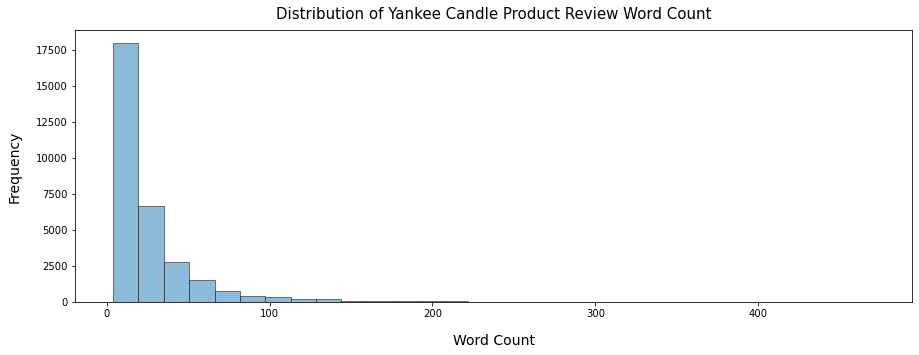

In [29]:
# Plot a histogram of the word counts.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(15, 5))
plt.hist(df['NumWords'], bins=30, edgecolor='black', linewidth=0.5, color='#8EBAD9')
plt.title('Distribution of Yankee Candle Product Review Word Count', y=1.02, fontsize=15)
plt.ylabel('Frequency', fontsize=14, labelpad=15)
plt.xlabel('Word Count', fontsize=14, labelpad=15)
plt.show()

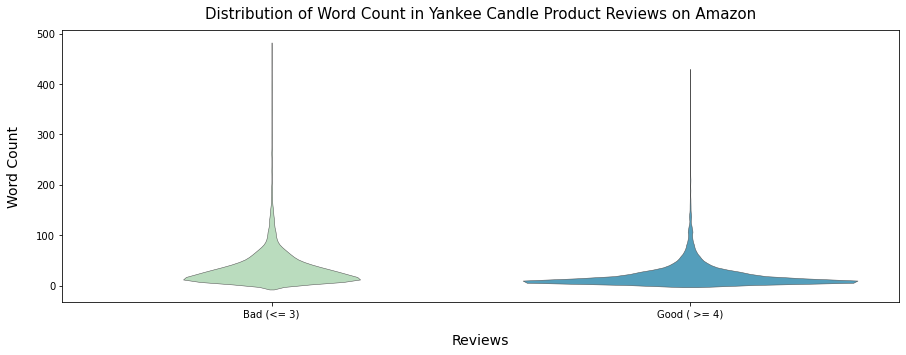

In [30]:
# Plot a violin of the word counts.
plt.figure(figsize=(15, 5))
sns.violinplot(data=df, x='Good Review', y='NumWords', split=True, inner=None, palette='GnBu', linewidth=0.5)
plt.title('Distribution of Word Count in Yankee Candle Product Reviews on Amazon', y=1.02, fontsize=15)
plt.xlabel('Reviews', fontsize=14, labelpad=15)
plt.ylabel('Word Count', fontsize=14, labelpad=15)
plt.xticks(np.arange(2), ('Bad (<= 3)', 'Good ( >= 4)'))
plt.show()

**Insights:**
* The reviews for Yankee Candle products on Amazon are generally quite short, with a mean length of 26 words.  The longest review is 471 words, although reviews over 100 words are rare.
* Bad reviews (rating <= 3) have a mean word count of 35 words and good reviews (rating >= 4) have a mean word count of 22 words.  It is not uncommon for bad reviews to be longer than good reviews, as customers typically use more words to express displeasure.

## 2. Explore Polarity

In [31]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Calculate polarity scores using the review content with stop words removed.
df['Compound'] = [analyzer.polarity_scores(str(v))['compound'] for v in df['sContent']]
df['Neg'] = [analyzer.polarity_scores(str(v))['neg'] for v in df['sContent']]
df['Neu'] = [analyzer.polarity_scores(str(v))['neu'] for v in df['sContent']]
df['Pos'] = [analyzer.polarity_scores(str(v))['pos'] for v in df['sContent']]
df.head(3)

,Title,Author,Date,Rating,Product,Helpfulness,Content,NumStopWords,NumPunctuation,NumHashtags,...,NumUpper,NumWords,NumChars,AvgWordLength,Good Review,sContent,Compound,Neg,Neu,Pos
0,Don't Order Candles When You're Drunk,Rachel,2018-09-28,1,"Size: Large Jar,Style: A Calm & Quiet Place,Pa...",262,"[a, the, title, state, i, suggest, that, you, ...",89,18,0,...,13,188,948,4.1,0,"[title, state, suggest, not, order, candle, yo...",-0.3987,0.114,0.790,0.096
1,Nice scent but something went wrong,Hayley,2020-11-05,1,"Size: Large Jar,Style: Midnight Jasmine,Patter...",1,"[i, love, candle, especially, jasmine, scent, ...",31,12,0,...,5,93,507,4.6,0,"[love, candle, especially, jasmine, scent, one...",0.9706,0.063,0.567,0.370
2,"I am almost, happy with this candle",Shepard,2017-06-23,4,"Size: Large Jar,Style: White Gardenia,Pattern ...",7,"[i, be, almost, happy, with, this, candle, for...",21,13,0,...,5,68,330,4.2,1,"[almost, happy, candle, reason, scent, not, st...",0.4118,0.116,0.724,0.160


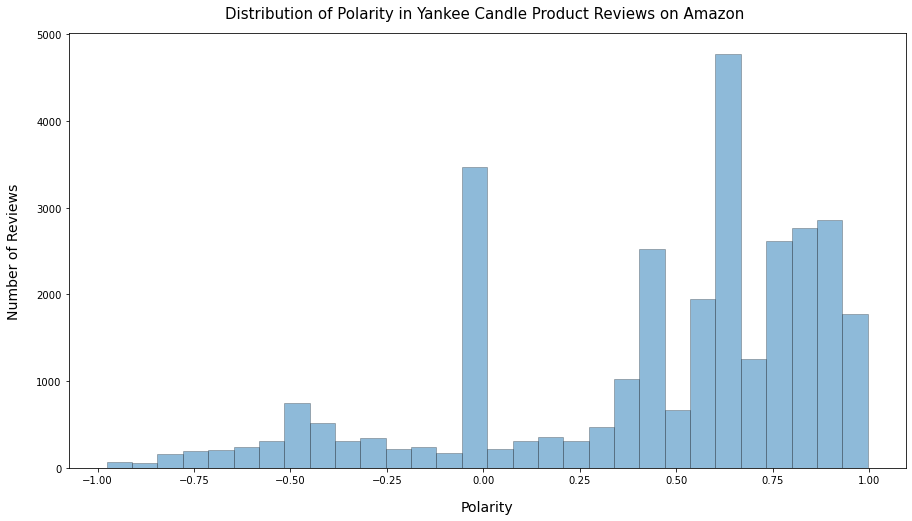

In [32]:
plt.figure(figsize=(15, 8))
plt.hist(df['Compound'], bins=30, alpha=0.5, edgecolor='black', linewidth=0.5)
plt.title('Distribution of Polarity in Yankee Candle Product Reviews on Amazon ', y=1.02, fontsize=15)
plt.xlabel('Polarity', fontsize=14, labelpad=15)
plt.ylabel('Number of Reviews', fontsize=14, labelpad=15)
plt.show();

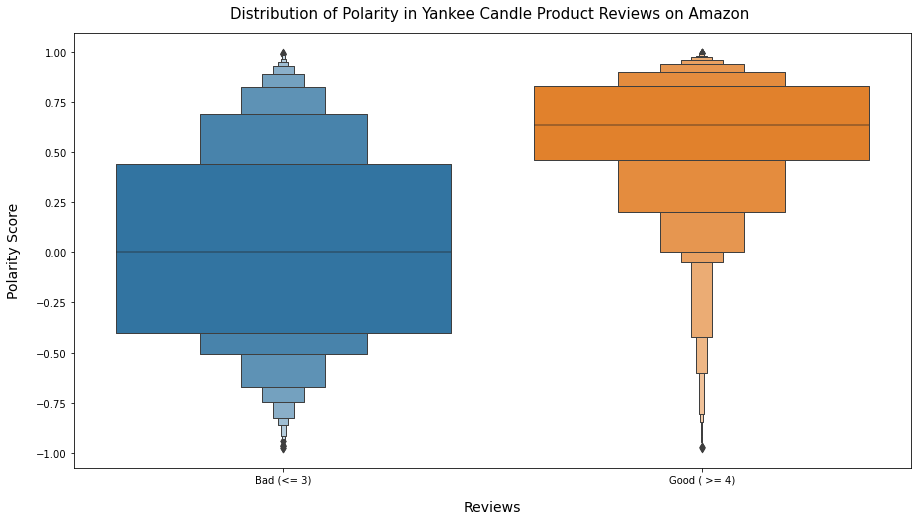

In [33]:
plt.figure(figsize=(15, 8))
sns.boxenplot(data=df, x='Good Review', y='Compound')
plt.title('Distribution of Polarity in Yankee Candle Product Reviews on Amazon ', y=1.02, fontsize=15)
plt.xlabel('Reviews', fontsize=14, labelpad=15)
plt.ylabel('Polarity Score', fontsize=14, labelpad=15)
plt.xticks(np.arange(2), ('Bad (<= 3)', 'Good ( >= 4)'))
plt.show();

**Insights:**
* The polarity of Yankee Candle product reviews on Amazon is generally positive, with a majority of reviews scoring between 0.5 and 1.0 (VADER Compound Score).  Most reviews with a negative polarity score are just below 0, so could be said to be neutral rather than negative.
* As to be expected, bad reviews (rating <= 3) on average have a lower polarity score than good reviews (rating >= 4) do.

## 3. Explore Subjectivity

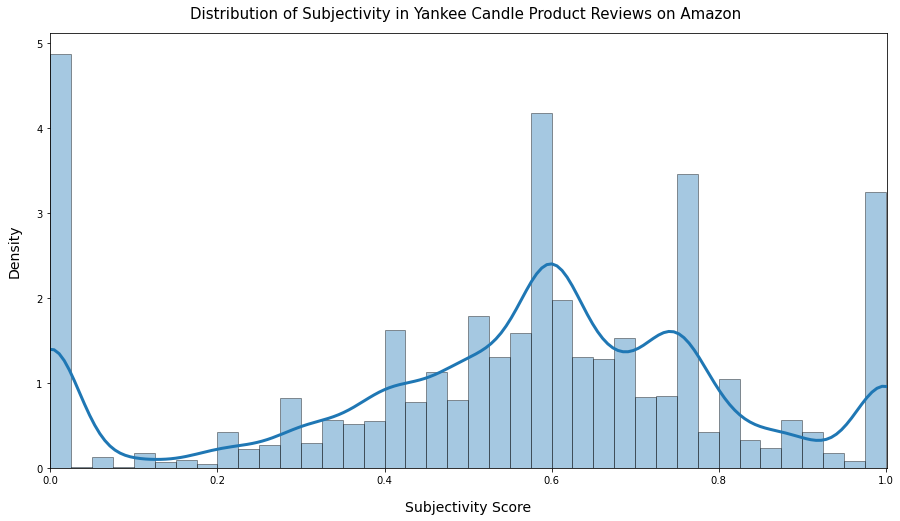

In [34]:
df['Subjectivity'] = df['sContent'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

plt.figure(figsize=(15,8))
sns.distplot(df['Subjectivity'],
             hist=True,
             kde=True,
             bins=int(40),
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3}
            )
plt.xlim([-0.001,1.001])
plt.title('Distribution of Subjectivity in Yankee Candle Product Reviews on Amazon ', y=1.02, fontsize=15)
plt.xlabel('Subjectivity Score', fontsize=14, labelpad=15)
plt.ylabel('Density', fontsize=14, labelpad=15)
plt.show()

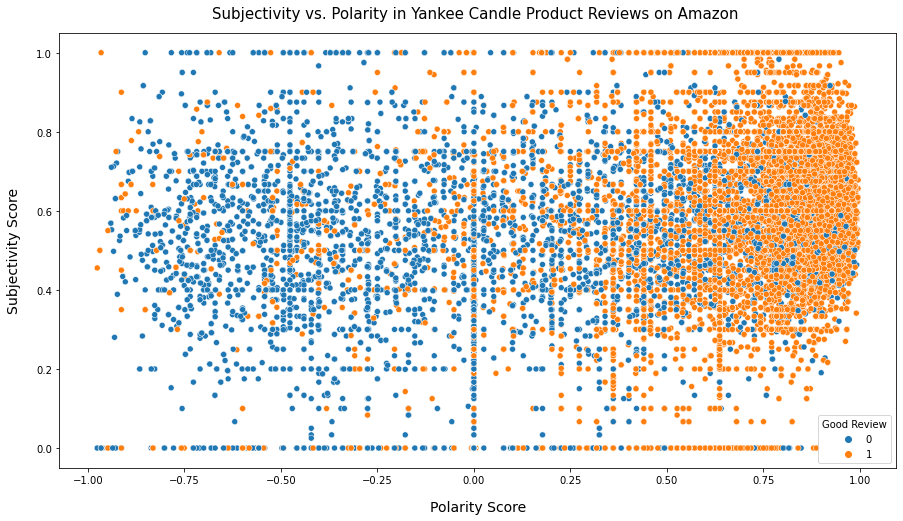

In [35]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=df, x='Compound', y='Subjectivity', hue='Good Review')
plt.title('Subjectivity vs. Polarity in Yankee Candle Product Reviews on Amazon ', y=1.02, fontsize=15)
plt.xlabel('Polarity Score', fontsize=14, labelpad=15)
plt.ylabel('Subjectivity Score', fontsize=14, labelpad=15)
plt.show()

**Insights:**
* A significant number of reviews for Yankee Candle products on Amazon have subjectivity scores of 0 (fact based) or 1 (opinion based).
* There is no clear relationship between the subjectivity of a review and whether it is a good review (rating >= 4) or a bad review (rating <= 3).  Although, it could be said that good reviews skew slightly towards being more opinion based than they are fact based.  The nature of reviews is that they are the opinion of the customer and the mean of the subjectivity score at 0.55 supports this bias.

### 4. Visualize Words Used in Reviews
**Objective:** Create word clouds of words present in reviews before and during the pandemic.

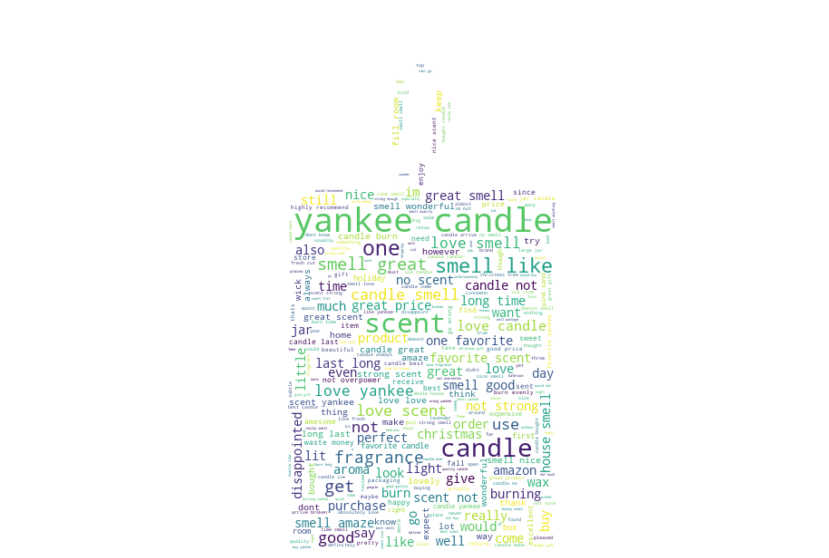

In [36]:
from wordcloud import WordCloud
from PIL import Image

# Flatten word lists.
def unlist(word_list):
    return ' '.join(word for word in word_list)
df['lContent'] = df.apply(lambda x: unlist(x['sContent']), axis=1)

# Filter for reviews before pandemic.
ldf = df[df['Date'] < '2020-01-01']

# Generate word cloud and display.
mask = np.array(Image.open('candle.jpg'))
text = " ".join(str(review) for review in ldf['lContent'])
wc = WordCloud(stopwords=stop, 
               mask=mask, background_color='white',
               max_words=2000, max_font_size=256, 
               random_state=42, height=1000)
wc.generate(text)

plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

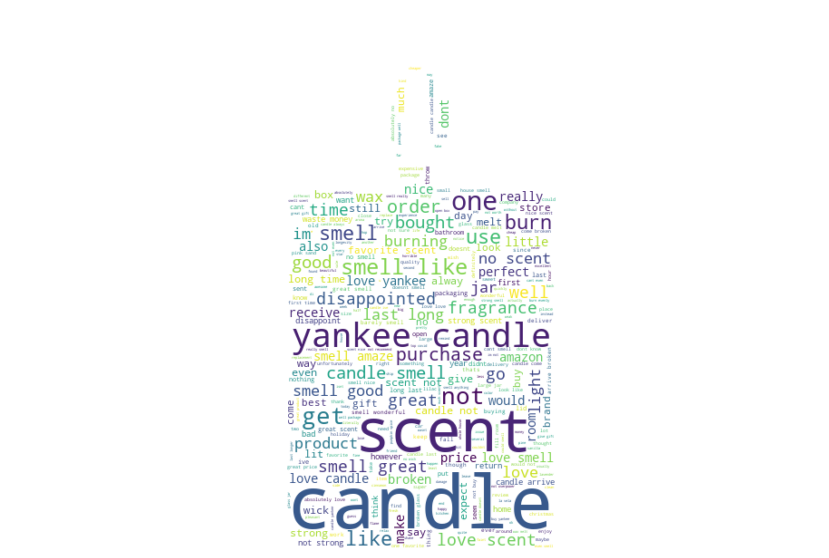

In [37]:
# Filter for reviews during pandemic.
ldf = df[df['Date'] >= '2020-04-01']

# Generate word cloud and display.
text = " ".join(str(review) for review in ldf['lContent'])
wc = WordCloud(stopwords=stop, 
               mask=mask, background_color='white',
               max_words=2000, max_font_size=256, 
               random_state=42, height=1000)
wc.generate(text)

plt.figure( figsize=(20,10) )
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

**Insights:** 
* From casual observation the bigram 'no scent' can be spotted in the word cloud representing reviews of Yankee Candle product during the pandemic.  Looking back at the word cloud representing reviews before the pandemic, the same bigram is still visible, but smaller in size.  This indicates that the bigram appears more frequently in reviews during the pandemic, relative to other ngrams.  The word 'disappointed' is also more prominent during the pandemic.

# Part D: Hypothesis Testing

**Hypothesis:** That average review ratings and sentiment for Yankee Candle products on Amazon have decreased in 2020, when compared to previous years, due to the common coronavirus sympton of a loss of smell.  My assertion is that purchasers of Yankee Candles blame the manufacturer for a lack of scent in the product, without realizing it is their own health condition that is at fault.

## 1. Trend of Good vs. Bad Reviews (%)
**Objective:** Construct a plot to show the trend of good vs. bad reviews over time, as a percentage of total reviews.  For this analysis good reviews are those with ratings of 4 and 5 and bad reviews are those with ratings of 1, 2 and 3.

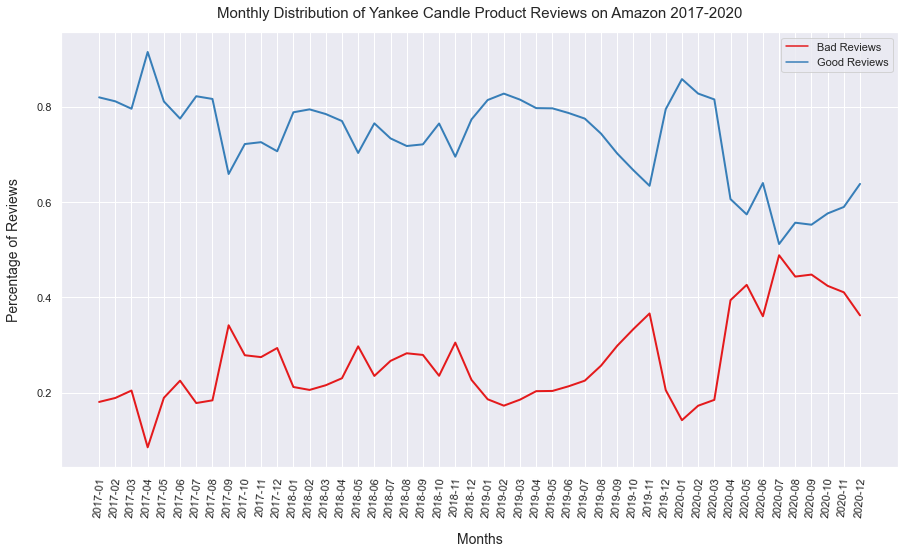

In [38]:
# Filter for observations after 01/01/2017 for plotting.
df_2017 = df[df['Date'] >= '2017-01-01'].groupby(df['Date'].dt.strftime('%Y-%m'))['Rating'].count().reset_index()

# Filter for observations with low and high ratings.
df_low = df[df['Rating'] <= 3]
df_low = df_low[df_low['Date'] >= '2017-01-01'].groupby(df_low['Date'].dt.strftime('%Y-%m'))['Rating'].count().reset_index()

df_high = df[df['Rating'] >= 4]
df_high = df_high[df_high['Date'] >= '2017-01-01'].groupby(df_high['Date'].dt.strftime('%Y-%m'))['Rating'].count().reset_index()

# Calculate low and high as proportions of all ratings. 
p_low = df_2017.copy()
p_low['Rating'] = df_low['Rating'] / df_2017['Rating']
p_high = df_2017.copy()
p_high['Rating'] = df_high['Rating'] / df_2017['Rating']

# Merge low and high proportions into single dataframe for plotting.
result = pd.merge(p_low, p_high, on='Date')
result.rename(columns={'Rating_x': 'Bad Reviews', 'Rating_y': 'Good Reviews'}, inplace=True)

sns.set_theme(style='darkgrid')
plt.figure(figsize=(15,8))

s = sns.lineplot(data=result, palette='Set1', dashes=False, linewidth=2)
s.set_title('Monthly Distribution of Yankee Candle Product Reviews on Amazon 2017-2020', y=1.02, fontsize=15)
s.set_xlabel('Months', fontsize=14, labelpad=15)
s.set_ylabel('Percentage of Reviews', fontsize=14, labelpad=15)
plt.xticks(np.arange(len(result['Date'])), result['Date'])

for item in s.get_xticklabels():
    item.set_rotation(85)

**Insights:**
* In the above line plot, there is a clear and significant decrease in good reviews for Yankee Candle products and a corresponding increase in bad reviews beginning in April 2020.  
* In July 2020 there were almost an equal number of good reviews and bad reviews for Yankee Candle products, for the first and only time.

## 2. Trend of Good vs Bad Reviews
**Objective:** Construct a plot to show the trend of the number of good vs. the number of bad reviews over time.

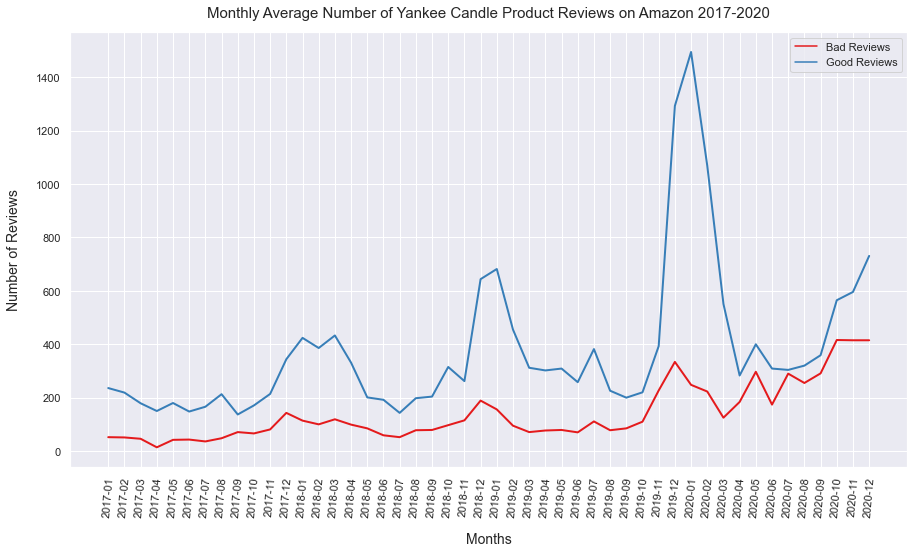

In [39]:
plt.figure(figsize=(15,8))

# Merge low and high ratings into single dataframe for plotting.
result = pd.merge(df_low, df_high, on='Date')
result.rename(columns={'Rating_x': 'Bad Reviews', 'Rating_y': 'Good Reviews'}, inplace=True)

s = sns.lineplot(data=result, palette='Set1', dashes=False, linewidth=2)
s.set_title('Monthly Average Number of Yankee Candle Product Reviews on Amazon 2017-2020', y=1.02, fontsize=15)
s.set_xlabel('Months', fontsize=14, labelpad=15)
s.set_ylabel('Number of Reviews', fontsize=14, labelpad=15)
plt.xticks(np.arange(len(result['Date'])), result['Date'])

for item in s.get_xticklabels():
    item.set_rotation(85)

**Insights:** 
* In the above line plot, it can be seen from April to September 2020 that the gap between the number of good reviews for Yankee Candle products and the number of bad reviews narrows, when compared to earlier months.  
* In July 2020 there were almost an equal number of good reviews and bad reviews for Yankee Candle products, for the first and only time.

## 3. Trend of Monthly Average Review Rating
**Objective:** Construct a plot to show the average review rating over time.

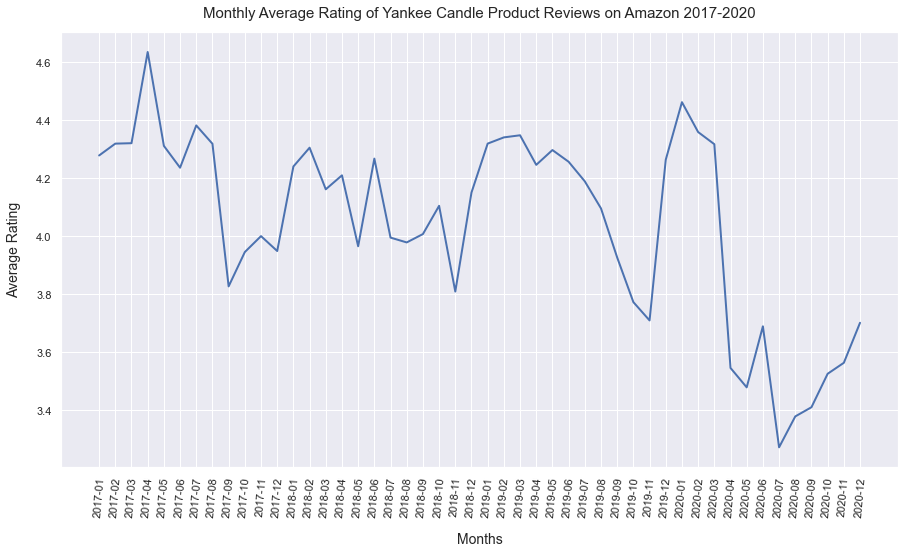

In [40]:
df_rating = df[df['Date'] >= '2017-01-01'].groupby(df['Date'].dt.strftime('%Y-%m'))['Rating'].mean()

plt.figure(figsize=(15,8))

s = sns.lineplot(data=df_rating, color='b', linewidth=2)
s.set_title('Monthly Average Rating of Yankee Candle Product Reviews on Amazon 2017-2020', y=1.02, fontsize=15)
s.set_xlabel('Months', fontsize=14, labelpad=15)
s.set_ylabel('Average Rating', fontsize=14, labelpad=15)

for item in s.get_xticklabels():
    item.set_rotation(85)

**Insights:** 
* In the above line plot, there is an obvious deterioration in the average review rating for Yankee Candle products in 2020, from the onset of the coronavirus pandemic.  Review ratings have dropped from an average of nearly 4.5 in January 2020 to between 3.3 and 3.6 in the subsequent months.
* There is a dip in average review ratings in Fall each year.  I will explore this observation later.
* In some years, following the Fall dip, there is a small peak in January that is usually higher than the peak just prior to the Fall dip.  This may be as a consequence of people receiving Yankee Candle products as gifts for Christmas and posting postive reviews and ratings.  I will also explore this observation later.

## 4. Trend of Monthly Average Sentiment and Monthly Average Review Rating
**Objective:** Construct a plot to show the average review rating compared to the average sentiment over time.  Compound scores from the VADER Sentiment Intensity Analyzer will be used to represent sentiment.

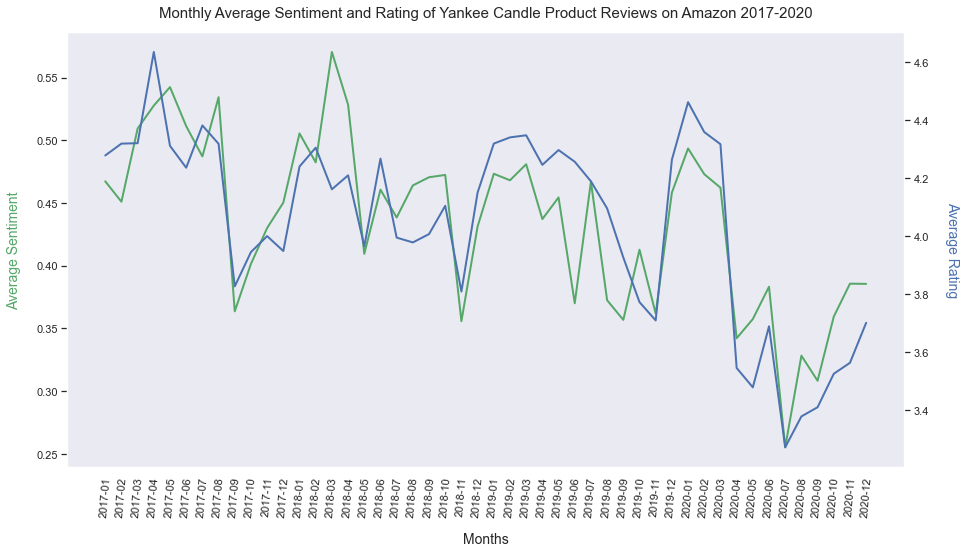

In [41]:
df_compound = df[df['Date'] >= '2017-01-01'].groupby(df['Date'].dt.strftime('%Y-%m'))['Compound'].mean()
df_rating = df[df['Date'] >= '2017-01-01'].groupby(df['Date'].dt.strftime('%Y-%m'))['Rating'].mean()

sns.set_theme(style='dark')
plt.figure(figsize=(15,8))

s = sns.lineplot(data=df_compound, color='g', linewidth=2)
s.set_title('Monthly Average Sentiment and Rating of Yankee Candle Product Reviews on Amazon 2017-2020', y=1.02, fontsize=15)
s.set_xlabel('Months', fontsize=14, labelpad=15)
s.set_ylabel('Average Sentiment', fontsize=14, labelpad=15, color='g')

ax2 = plt.twinx()
t = sns.lineplot(data=df_rating, ax=ax2, linewidth=2)
t.set_ylabel('Average Rating', fontsize=14, labelpad=30, rotation=-90, color='b')

for item in s.get_xticklabels():
    item.set_rotation(85)

**Insight:** 
* In the above line plot, monthly average review ratings for Yankee Candle products closely track the average sentiment of the reviews, as measured by the VADER Sentiment Intensity Analyzer.  This includes in Fall each year when there is a cyclical dip and in 2020 during the coronavirus pandemic.

## 5. Trend of Monthly Average Sentiment Components
**Objective:** Construct a plot to show average sentiment over time.

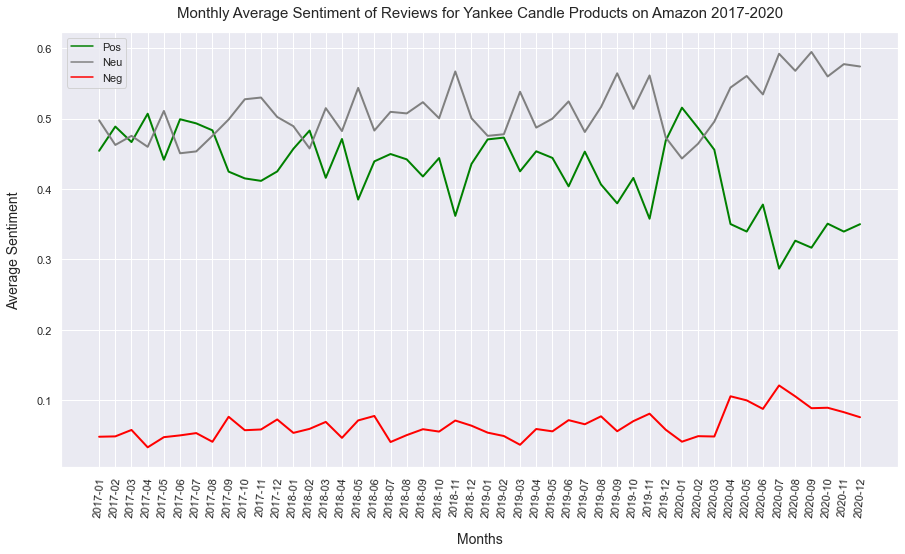

In [42]:
df_pos = df[df['Date'] >= '2017-01-01'].groupby(df['Date'].dt.strftime('%Y-%m'))[['Pos']].mean()
df_neu = df[df['Date'] >= '2017-01-01'].groupby(df['Date'].dt.strftime('%Y-%m'))[['Neu']].mean()
df_neg = df[df['Date'] >= '2017-01-01'].groupby(df['Date'].dt.strftime('%Y-%m'))[['Neg']].mean()

sns.set_theme(style='darkgrid')
plt.figure(figsize=(15,8))

s = sns.lineplot(data=df_pos, palette=['green'], linewidth=2)
s = sns.lineplot(data=df_neu, palette=['grey'], linewidth=2)
s = sns.lineplot(data=df_neg, palette=['red'], linewidth=2)
s.set_title('Monthly Average Sentiment of Reviews for Yankee Candle Products on Amazon 2017-2020', y=1.02, fontsize=15)
s.set_xlabel('Months', fontsize=14, labelpad=15)
s.set_ylabel('Average Sentiment', fontsize=14, labelpad=15)

for item in s.get_xticklabels():
    item.set_rotation(85)

**Insights:** 
* In the above line plot, the average VADER positive, neutral and negative scores remain relatively stable until 2020, when the positive score starts to trend down and both the neutral and negative scores trend up.  This is a reflection of the overall decrease in sentiment expressed in the reviews of Yankee Candle products on Amazon in 2020.
* The cyclical Fall dip can also be observed in this line plot.  It appears that the Fall dip reflects a decrease in the average positive score and a corresponding increase in the average neutral score for the month.  There is no material change in the average negative score during the Fall dip.  So, it could be said that sentiment expressed in reviews becomes more neutral and less positive, but not more negative. 

## 6. Sentiment of Reviews Before and During Pandemic
**Objective:** Construct plots to compare the distribution of sentiment before and during the pandemic.

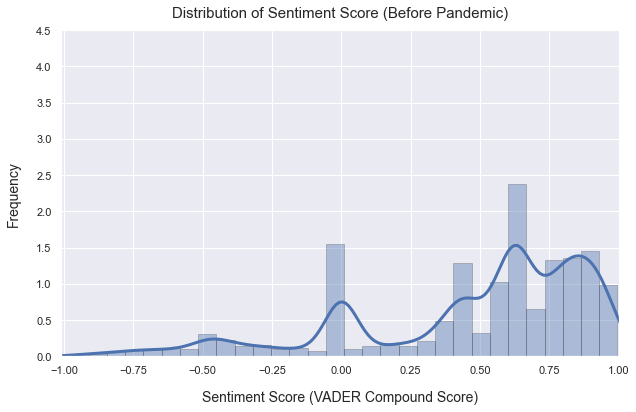

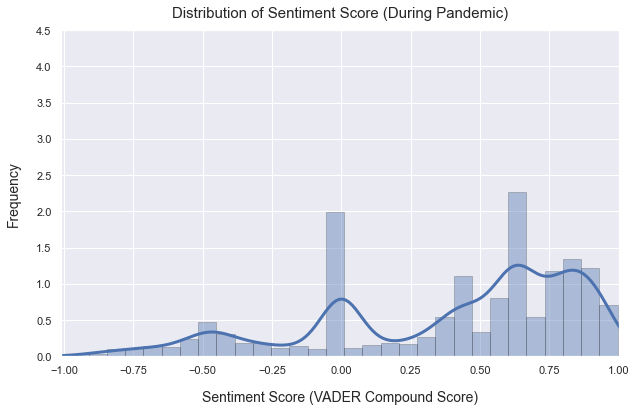

In [43]:
df_before = df[df['Date'] < '2020-01-01']
df_after = df[df['Date'] >= '2020-01-01']

plt.figure(figsize=(10,6))
sns.distplot(df_before['Compound'], hist=True, kde=True, bins=int(30), 
             hist_kws={'edgecolor':'black', 'linewidth': '0.5'}, kde_kws={'linewidth': 3})
plt.xlim([-1.01,1.001])
plt.ylim([0, 4.5])
plt.xlabel('Sentiment Score (VADER Compound Score)', fontsize=14, labelpad=15)
plt.ylabel('Frequency', fontsize=14, labelpad=15)
plt.title('Distribution of Sentiment Score (Before Pandemic)', fontsize=15, y=1.02)
plt.show()

print()

plt.figure(figsize=(10,6))
sns.distplot(df_after['Compound'], hist=True, kde=True, bins=int(30), 
             hist_kws={'edgecolor':'black', 'linewidth': '0.5'}, kde_kws={'linewidth': 3})
plt.xlim([-1.01,1.001])
plt.ylim([0, 4.5])
plt.xlabel('Sentiment Score (VADER Compound Score)', fontsize=14, labelpad=15)
plt.ylabel('Frequency', fontsize=14, labelpad=15)
plt.title('Distribution of Sentiment Score (During Pandemic)', fontsize=15, y=1.02)
plt.show()

**Insights:** 
* In the above plots it is evident that there is a material shift to the left in the distribution of the sentiment of reviews during the pandemic when compared to before the pandemic.  This is consistent with the decrease in the average review ratings.

## 7. Nature of Reviews Before and During Pandemic

### 7.1 Explore Bigrams & Trigrams
**Objective:** Compare bigrams and trigrams present in reviews before and during the pandemic to determine whether the nature of reviews differs between the two time periods.

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer and create a matrix of bigrams and trigrams for reviews before the pandemic.
vectorizer = CountVectorizer(stop_words=stop, ngram_range=(2,3))
ngrams = vectorizer.fit_transform(df_before['lContent'])

# Count the frequency of the ngrams and create a dataframe.
count_values = ngrams.toarray().sum(axis=0)
vocab = vectorizer.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'Frequency', 1:'Ngram'})

df_ngram.head(50)

,Frequency,Ngram
0,4395,yankee candle
1,1466,smell like
2,1011,smell great
3,831,love scent
4,725,candle smell
5,703,love yankee
6,638,love yankee candle
7,630,love smell
8,625,love candle
9,581,smell good


In [45]:
# Create a matrix of bigrams and trigrams for reviews during the pandemic.
ngrams = vectorizer.fit_transform(df_after['lContent'])

# Count the frequency of the ngrams and create a dataframe.
count_values = ngrams.toarray().sum(axis=0)
vocab = vectorizer.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'Frequency', 1:'Ngram'})

df_ngram.head(50)

,Frequency,Ngram
0,1863,yankee candle
1,638,smell like
2,451,love scent
3,413,smell great
4,370,candle smell
5,338,last long
6,322,love yankee
7,311,smell good
8,291,no scent
9,289,love yankee candle


**Insights:** 
* Four of the top 50 bigrams/trigrams in Yankee Candle product reviews on Amazon before the coronavirus pandemic relate to a lack of scent (scent not, no scent, not strong, not smell), whereas 7 of the top 50 in product reviews during the pandemic relate to a lack of scent (no scent, scent not, not strong, not smell, no smell, barely smell, smell not).
* The ratio of the lack of scent ngrams appearing in product reviews before the pandemic is 1,255 occurences of the ngrams to 20,806 product reviews (0.06:1), whereas during the pandemic the ratio is 1,097 occurences of the ngrams to 10,315 product reviews (0.11:1).

### 7.2 Explore Topics [Topic Modeling]
**Objective:** Determine if there is a difference in topics between Yankee Candle product reviews on Amazon before and during the coronavirus pandemic.

**Method:** 
1. Use Gensim's NMF and Coherence models to determine the optimal number of topics.
2. Use TfidfVectorizer and an NMF model to determine the topics for review comments before the pandemic.
3. Repeat to determine the topics for review comments during the pandemic and compare.

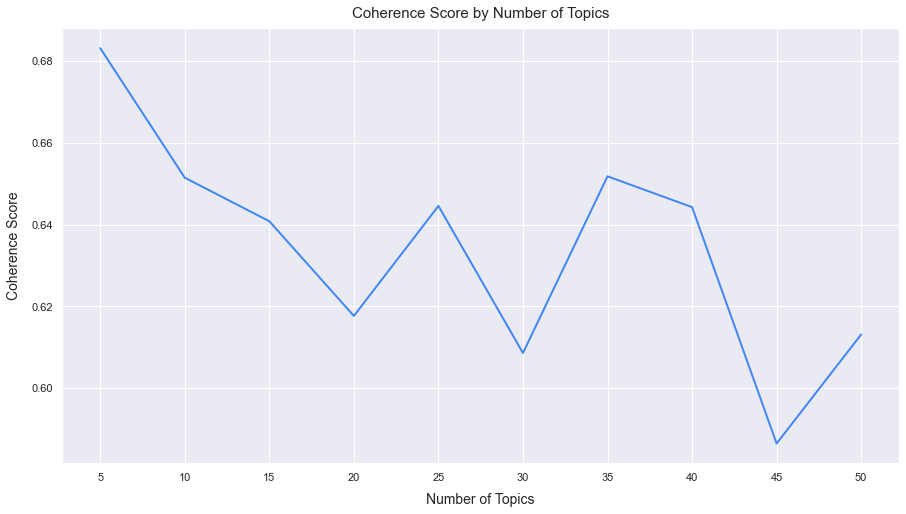

In [46]:
# 1. Use Gensim's NMF and Coherence models to determine the optimal number of topics.

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from operator import itemgetter

all_content = df['sContent']

# Create a dictionary to map between words and their integer ID.
dictionary = Dictionary(all_content)

# Filter out extremes to limit the number of features.
dictionary.filter_extremes(
    no_below=10,
    no_above=0.95,
    keep_n=5000
)

# Convert into bag of words format.
corpus = [dictionary.doc2bow(content) for content in all_content]

# Create a list of topic numbers to evaluate.
num_topics = list(np.arange(5, 50 + 1, 5))

# Run the NMF model to calculate a coherence score for each number of topics.
coherence_scores = []

for num in num_topics:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=0.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the scores.
    cm = CoherenceModel(
        model=nmf,
        texts=all_content,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score.
scores = list(zip(num_topics, coherence_scores))
best_num = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results.
plt.figure(figsize=(15, 8))
plt.plot(num_topics, coherence_scores, linewidth=2, color='#4287f5')
plt.xlabel('Number of Topics', fontsize=14, labelpad=10)
plt.ylabel('Coherence Score', fontsize=14, labelpad=10)
plt.title('Coherence Score by Number of Topics', fontsize=15, y=1.01, loc='center')
plt.xticks(np.arange(5, max(num_topics) + 1, 5))
plt.show()

In [47]:
# 2. Use TfidfVectorizer and an NMF model to determine the topics for review comments before the pandemic.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

all_content = df_before['sContent']

# Determine the TF-IDF weights.
tfidf_vectorizer = TfidfVectorizer(
    min_df=10,
    max_df=0.95,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor= ' '.join
)

tfidf = tfidf_vectorizer.fit_transform(all_content)

# Save the feature names to create topic summaries later.
tfidf_features = tfidf_vectorizer.get_feature_names()

# Run the NMF model.
nmf = NMF(
    n_components = best_num,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state = 42
).fit(tfidf)


# Generate a dataframe containing the topics and clean it up for presentation.
from nltk.tokenize import RegexpTokenizer

def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  

def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens

def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist

docweights = nmf.transform(tfidf_vectorizer.transform(all_content))

n_top_words = 8

df_topics = topic_table(
    nmf,
    tfidf_features,
    n_top_words
).T

# Cleaning up the dataframe for presentation.
df_topics['Topic'] = df_topics.apply(lambda x: [' '.join(x)], axis=1) # Join the words into a list.
df_topics['Topic'] = df_topics['Topic'].str[0]  # Remove the list brackets.
df_topics['Topic'] = df_topics['Topic'].apply(lambda x: whitespace_tokenizer(x)) # Tokenize.
df_topics['Topic'] = df_topics['Topic'].apply(lambda x: unique_words(x))  # Remove duplicate words.
df_topics['Topic'] = df_topics['Topic'].apply(lambda x: [' '.join(x)])  # Joining the words into a list.
df_topics['Topic'] = df_topics['Topic'].str[0]  # Remove the list brackets.
df_topics.head()

,0,1,2,3,4,5,6,7,Topic
0,love,love smell,love scent,love candle,love yankee,love love,smell,love fragrance,love smell scent candle yankee fragrance
1,great,smell great,smell,great smell,great scent,great price,price,great candle,great smell scent price candle
2,candle,yankee,yankee candle,smell,like,not,love yankee,best,candle yankee smell like not love best
3,good,smell good,smell,good price,love smell,price,good smell,good quality,good smell price love quality
4,scent,love scent,favorite,nice,favorite scent,great scent,nice scent,one favorite,scent love favorite nice great one


In [48]:
# 3. Repeat to determine the topics for review comments during the pandemic and compare.

all_content = df_after['sContent']

tfidf = tfidf_vectorizer.fit_transform(all_content)

# Save the feature names to create topic summaries later.
tfidf_features = tfidf_vectorizer.get_feature_names()

# Run the NMF model.
nmf = NMF(
    n_components=best_num,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42
).fit(tfidf)

# Generate a dataframe containing the topics and clean it up for presentation.
docweights = nmf.transform(tfidf_vectorizer.transform(all_content))

df_topics = topic_table(
    nmf,
    tfidf_features,
    n_top_words
).T

# Cleaning up the dataframe for presentation.
df_topics['Topic'] = df_topics.apply(lambda x: [' '.join(x)], axis=1) # Join the words into a list.
df_topics['Topic'] = df_topics['Topic'].str[0]  # Remove the list brackets.
df_topics['Topic'] = df_topics['Topic'].apply(lambda x: whitespace_tokenizer(x)) # Tokenize.
df_topics['Topic'] = df_topics['Topic'].apply(lambda x: unique_words(x))  # Remove duplicate words.
df_topics['Topic'] = df_topics['Topic'].apply(lambda x: [' '.join(x)])  # Joining the words into a list.
df_topics['Topic'] = df_topics['Topic'].str[0]  # Remove the list brackets.
df_topics.head()

,0,1,2,3,4,5,6,7,Topic
0,candle,yankee,yankee candle,love yankee,not,one,broken,best,candle yankee love not one broken best
1,love,love scent,love smell,love candle,love yankee,love love,gift,daughter,love scent smell candle yankee gift daughter
2,great,smell great,great smell,smell,price,great price,great scent,gift,great smell price scent gift
3,smell,good,like,amaze,smell good,smell amaze,smell like,love smell,smell good like amaze love
4,scent,love scent,favorite,favorite scent,last,long,nice,no scent,scent love favorite last long nice no


**Insights:** 
* There is no material difference between the topics before and during the pandemic according to this modeling.  The increase in review comments regarding 'no scent' in Yankee Candle products was not significant enough to change the topics identified.

## Conclusions

Based on the analysis performed, we can accept the hypothesis that the review ratings and sentiment for Yankee Candle products on Amazon have decreased in 2020, when compared to previous years and this is likely due to the common coronavirus symptom of a loss of smell.

My conclusion is based on the following observations and insights from my analysis:
* There is a clear and significant decrease in good reviews for Yankee Candle products and a corresponding increase in bad reviews beginning in April 2020.  In July 2020 there were almost an equal number of good reviews and bad reviews for Yankee Candle products, for the first and only time.
* It can be seen from April to September 2020 that the gap between the number of good reviews for Yankee Candle products and the number of bad reviews narrows, when compared to earlier months.  History shows that there are usually substantially more good reviews than bad reviews for Yankee Candle products on Amazon.
* There is an obvious deterioration in the average review rating for Yankee Candle products in 2020, from the onset of the coronavirus pandemic. Review ratings have dropped from an average of nearly 4.5 in January 2020 to between 3.3 and 3.6 in the subsequent months.
* The average VADER positive, neutral and negative scores remain relatively stable until 2020, when the positive score starts to trend down and both the neutral and negative scores trend up. This is a reflection of the overall decrease in sentiment expressed in the reviews of Yankee Candle products on Amazon in 2020.
* It is evident that there is a material shift to the left in the distribution of the sentiment of reviews during the pandemic when compared to before the pandemic. This is consistent with the decrease in the average review ratings.
* Four of the top 50 bigrams/trigrams in Yankee Candle product reviews on Amazon before the coronavirus pandemic relate to a lack of scent (scent not, no scent, not strong, not smell), whereas 7 of the top 50 in product reviews during the pandemic relate to a lack of scent (no scent, scent not, not strong, not smell, no smell, barely smell, smell not).  The ratio of the lack of scent ngrams appearing in product reviews before the pandemic is 1,255 occurences of the ngrams to 20,806 product reviews (0.06:1), whereas during the pandemic the ratio is 1,097 occurences of the ngrams to 10,315 product reviews (0.11:1).